# Analysis of ICESat-2/ATLAS transects at field sites

with field observations at ground level (TODO) and from UAV  

Paul Montesano, PhD  
Sept. 2024

In [1]:
import os
import pandas as pd
import geopandas as gpd
import glob
import rasterio
import pyproj
import matplotlib.pyplot as plt

/tmp/ipykernel_4055466/2082607704.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
import plotnine
from plotnine import *

In [3]:
EXPEDITION_ID = 'sewardpen2024'
OUTDIR = f'/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs/data/field/{EXPEDITION_ID}'

In [4]:
fn_atl03_gdf_list = glob.glob(f'{OUTDIR}/sewardpen2024_*_classified_photons_ATL03.gpkg')

In [5]:
fn_atl08_gdf_list = glob.glob(f'{OUTDIR}/sewardpen2024_*_ATL08.gpkg')

In [6]:
atl08_30m_gdf_roads = gpd.read_file('/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs/data/arc/atl08_seward_2km_roads.gpkg')

In [7]:
footprint_uav_gdf = gpd.read_file(f'{OUTDIR}/footprints_uav_sewardpen2024_RGB_COG.gpkg')

#### Get ATL08 30m for all sites
Overlay with footprints to get field site for ATL08 30m

In [8]:
atl08_30m_gdf = gpd.overlay(atl08_30m_gdf_roads, footprint_uav_gdf[['geometry','site']])

/tmp/ipykernel_4055466/4220505210.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:7912
Right CRS: EPSG:4326



In [9]:
atl08_30m_gdf.rename(columns={'y': 'year'}, inplace=True)
### ATL08: convert WGS84 coordinates to NSIDC EASE-Grid 2.0 Global
atl08_30m_gdf['x'] , atl08_30m_gdf['y'] = pyproj.transform(pyproj.Proj(init='epsg:4326'), pyproj.Proj(init='epsg:6933'), atl08_30m_gdf.geometry.x, atl08_30m_gdf.geometry.y)

/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
/tmp/ipykernel_4055466/3889298877.py:3: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1


In [10]:
def wrapper_attr_site_name_gdf(fn):
    gdf = gpd.read_file(fn) 
    gdf['site'] = os.path.basename(fn).split('_')[1] + '_' + os.path.basename(fn).split('_')[2]
    return gdf

In [11]:
atl03_field_gdf = pd.concat([wrapper_attr_site_name_gdf(fn) for fn in fn_atl03_gdf_list])
atl08_field_gdf = pd.concat([wrapper_attr_site_name_gdf(fn) for fn in fn_atl08_gdf_list])

In [12]:
sorted(atl08_field_gdf.site.unique())

['council_01',
 'council_02',
 'kougarok_01',
 'kougarok_02',
 'kougarok_03',
 'kougarok_04',
 'kougarok_05',
 'kougarok_06',
 'teller_01']

In [13]:
sorted(footprint_uav_gdf.site.unique())

['council_01',
 'council_02',
 'kougarok_01',
 'kougarok_02',
 'kougarok_03',
 'kougarok_04',
 'kougarok_05',
 'kougarok_06',
 'teller_01']

In [14]:
atl03_field_gdf.class_name.unique()

array(['Ground', 'Top of canopy', 'Canopy'], dtype=object)

In [15]:
class_name_list =  list(reversed(['Noise','Ground','Canopy','Top of canopy'][1:]))
class_color_list = list(reversed(['lightgrey','brown','lightgreen','darkgreen'][1:]))

In [16]:
atl03_field_gdf['class_name'] = pd.Categorical(atl03_field_gdf['class_name'], class_name_list)
atl03_field_gdf['year'] = pd.Categorical(atl03_field_gdf['year'], range(2018,2024))

In [17]:
atl03_field_gdf.class_name.unique()

['Ground', 'Top of canopy', 'Canopy']
Categories (3, object): ['Top of canopy', 'Canopy', 'Ground']

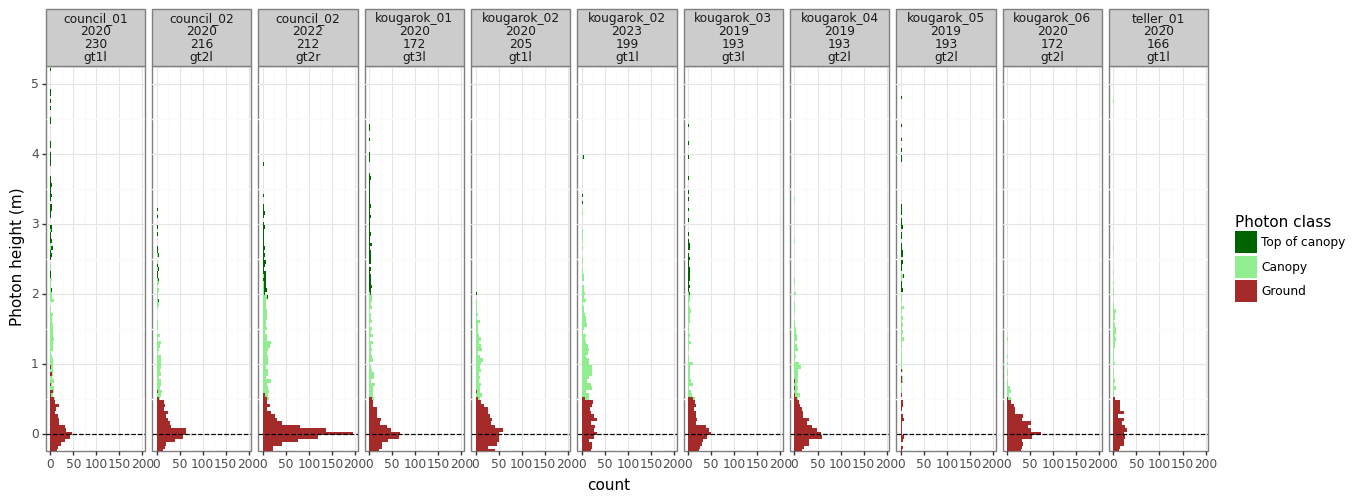

<ggplot: (1410920601585)>

In [18]:
plotnine.options.figure_size = (15, 5)

(
      ggplot(atl03_field_gdf, aes('height', fill='class_name', group='class_name'))
        + labs(x = 'Photon height (m)')
        + scale_fill_manual(values = class_color_list, labels=class_name_list, name='Photon class')
        + geom_histogram(binwidth=0.05)
        + geom_vline(xintercept=0, linetype='dashed', size=0.5, color='black')
        + facet_wrap(' ~ site + year + doy + beam', ncol=11)#, scales = 'free_x')
    + coord_flip(xlim = (0,5))
    + theme_bw() 
)

### Extract UAV DSM to ATL03, ATL08 100m, and ATL08 30m

In [19]:
DSM_DIR = f'{OUTDIR}/DSM_COG'
DTM_DIR = f'{OUTDIR}/DTM_COG'

fn_uavdsm_list = sorted(glob.glob(f'{DSM_DIR}/*.tif'))
fn_uavdtm_list = sorted(glob.glob(f'{DTM_DIR}/*.tif'))

### Extract UAV DSM & DTM pixels to ATL03 photons

In [20]:
def extract_uav_points_for_site(gdf_site, dsm_ds, dtm_ds, bandnum):
    coord_list = [(x,y) for x,y in zip(gdf_site['geometry'].x , gdf_site['geometry'].y)]
    gdf_site['dsm_uav'] = pd.Series([x[bandnum-1] for x in dsm_ds.sample(coord_list)])
    gdf_site['dtm_uav'] = pd.Series([x[bandnum-1] for x in dtm_ds.sample(coord_list)])
    gdf_site['height_uav'] = gdf_site['dsm_uav'] - gdf_site['dtm_uav']
    return gdf_site

In [21]:
atl08_field_gdf['geometry'] = atl08_field_gdf.centroid

/tmp/ipykernel_4055466/1591679515.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



In [22]:
atl03_gdf_list = []
atl08_gdf_list = []
atl08_30m_gdf_list = []
bandnum = 1

for i, site in enumerate(sorted(atl03_field_gdf.site.unique())):
    
    dsm_ds = rasterio.open(fn_uavdsm_list[i])
    dtm_ds = rasterio.open(fn_uavdtm_list[i])
        
    atl03_gdf_list.append( extract_uav_points_for_site(atl03_field_gdf[atl03_field_gdf.site == site].to_crs(dsm_ds.crs), dsm_ds, dtm_ds, bandnum) ) 
    atl08_gdf_list.append( extract_uav_points_for_site(atl08_field_gdf[atl08_field_gdf.site == site].to_crs(dsm_ds.crs), dsm_ds, dtm_ds, bandnum) ) 
    atl08_30m_gdf_list.append( extract_uav_points_for_site(atl08_30m_gdf[atl08_30m_gdf.site == site].to_crs(dsm_ds.crs), dsm_ds, dtm_ds, bandnum) ) 

In [23]:
atl03_field_gdf = pd.concat(atl03_gdf_list)
atl08_field_gdf = pd.concat(atl08_gdf_list)
atl08_30m_field_gdf = pd.concat(atl08_30m_gdf_list)

In [84]:
atl03_field_gdf[(atl03_field_gdf.site == 'council_02') & (atl03_field_gdf.dsm_uav !=-10000)]

,lon,lat,elev,class,height,quality,class_name,color,x,y,beam,atl03_granule,datetime,year,doy,geometry,site,dsm_uav,dtm_uav,height_uav
798,-163.808392,64.764126,97.196541,2,1.275772,4,Canopy,lightgreen,-1.580526e+07,6.636067e+06,gt2r,ATL03_20220731080119_06021603_006_02.h5,2022-07-31 08:01:19,2022,212,POINT (556684.676 7182700.503),council_02,64.667641,64.618698,0.048943
799,-163.808393,64.764132,96.978722,2,1.132812,4,Canopy,lightgreen,-1.580526e+07,6.636067e+06,gt2r,ATL03_20220731080119_06021603_006_02.h5,2022-07-31 08:01:19,2022,212,POINT (556684.587 7182701.208),council_02,64.567924,64.562683,0.005241
800,-163.808395,64.764138,98.481140,3,2.774818,4,Top of canopy,darkgreen,-1.580526e+07,6.636068e+06,gt2r,ATL03_20220731080119_06021603_006_02.h5,2022-07-31 08:01:19,2022,212,POINT (556684.496 7182701.918),council_02,64.670242,64.601059,0.069183
801,-163.808397,64.764145,96.725807,2,1.084167,4,Canopy,lightgreen,-1.580526e+07,6.636068e+06,gt2r,ATL03_20220731080119_06021603_006_02.h5,2022-07-31 08:01:19,2022,212,POINT (556684.408 7182702.618),council_02,64.555031,64.540520,0.014511
802,-163.808400,64.764157,96.903252,2,1.322647,4,Canopy,lightgreen,-1.580526e+07,6.636069e+06,gt2r,ATL03_20220731080119_06021603_006_02.h5,2022-07-31 08:01:19,2022,212,POINT (556684.229 7182704.030),council_02,64.619942,64.575485,0.044456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2102,-163.809481,64.768363,71.903625,1,-0.053284,4,Ground,brown,-1.580537e+07,6.636300e+06,gt2r,ATL03_20220731080119_06021603_006_02.h5,2022-07-31 08:01:19,2022,212,POINT (556624.011 7183171.705),council_02,44.176899,44.177097,-0.000198
2103,-163.809481,64.768363,71.967705,1,0.027039,4,Ground,brown,-1.580537e+07,6.636300e+06,gt2r,ATL03_20220731080119_06021603_006_02.h5,2022-07-31 08:01:19,2022,212,POINT (556624.011 7183171.705),council_02,44.176899,44.177097,-0.000198
2104,-163.809481,64.768363,72.005264,1,0.054024,4,Ground,brown,-1.580537e+07,6.636300e+06,gt2r,ATL03_20220731080119_06021603_006_02.h5,2022-07-31 08:01:19,2022,212,POINT (556624.011 7183171.705),council_02,44.176899,44.177097,-0.000198
2105,-163.809481,64.768363,72.062988,1,0.132111,4,Ground,brown,-1.580537e+07,6.636300e+06,gt2r,ATL03_20220731080119_06021603_006_02.h5,2022-07-31 08:01:19,2022,212,POINT (556624.011 7183171.705),council_02,44.176899,44.177097,-0.000198


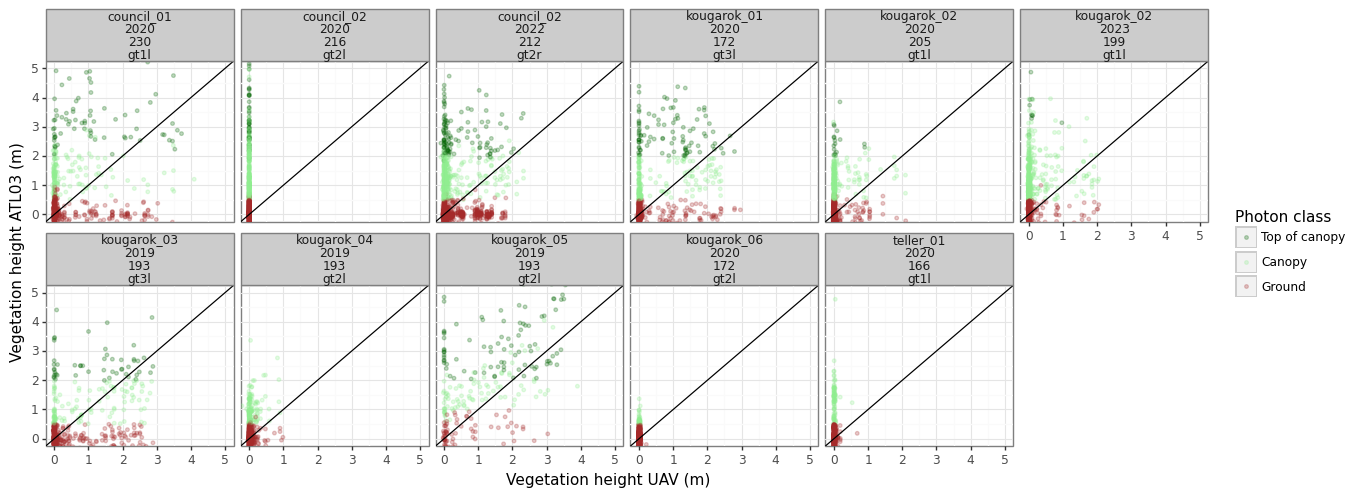

<ggplot: (1410827009401)>

In [82]:
plotnine.options.figure_size = (15, 5)

(
      ggplot(atl03_field_gdf, aes(y='height', x='height_uav'))
        + labs(x = 'Vegetation height UAV (m)', y= 'Vegetation height ATL03 (m)')
        #+ geom_bin2d(binwidth=0.2)
        + scale_color_manual(values = class_color_list, labels=class_name_list, name='Photon class')
        + geom_point(aes(color='class_name', group='class_name'), size=1, alpha=0.25)
        + geom_abline()
        + facet_wrap(' ~ site + year + doy + beam', ncol=6)#, scales = 'free_x')
    + coord_cartesian(xlim = (0,5), ylim = (0,5))
    + theme_bw() 
)

## Plot transects of height & elevation by site
#### TODO: shift ATL08 to align correctly with ATL03 along the transect
#### TODO: put UAV into same vertical datum as ICESat-2
#### TODO: find missing ATL08 30 for a couple lines

In [87]:
import plotlib
import importlib
importlib.reload(plotlib)

<module 'plotlib' from '/panfs/ccds02/home/pmontesa/code/above-shrubs/notebooks/plotlib.py'>

teller_01


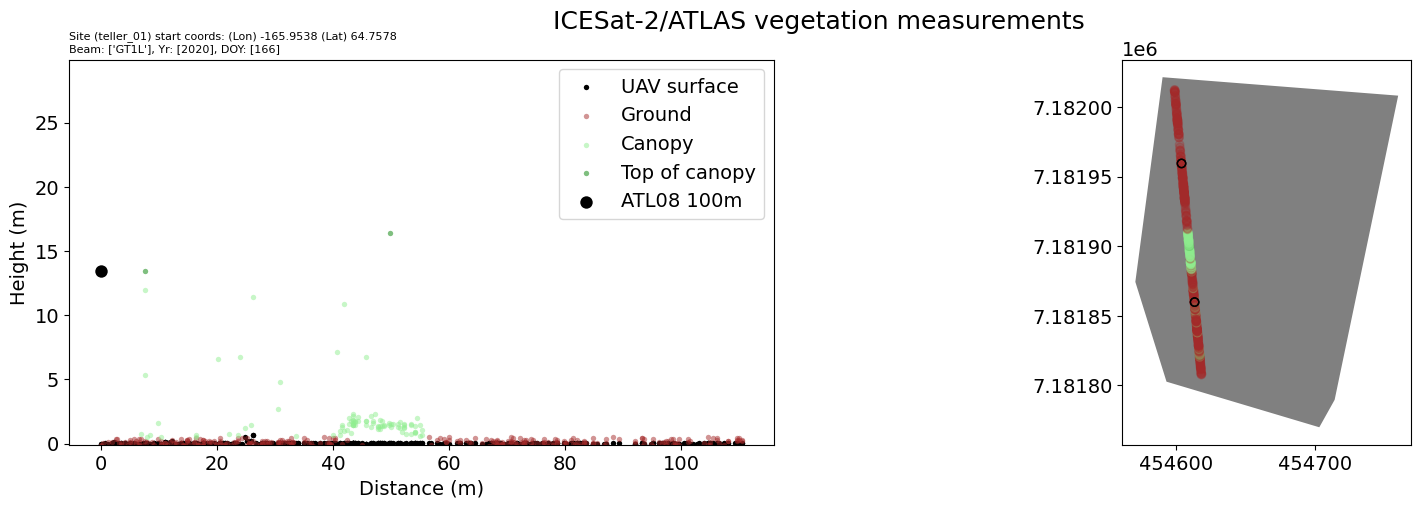

kougarok_06


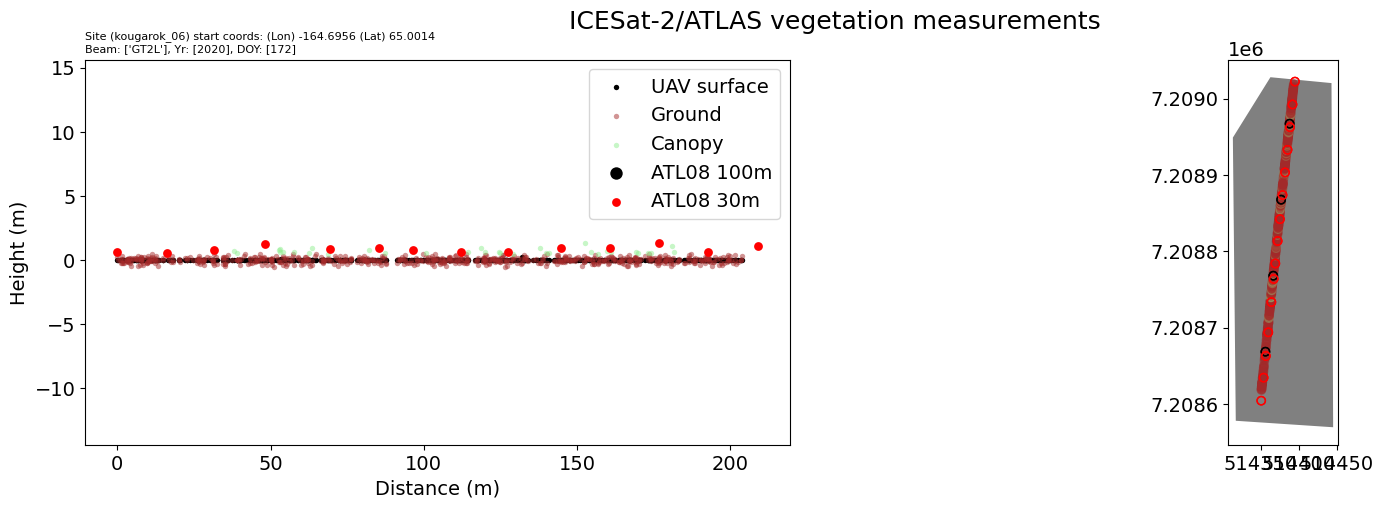

kougarok_05


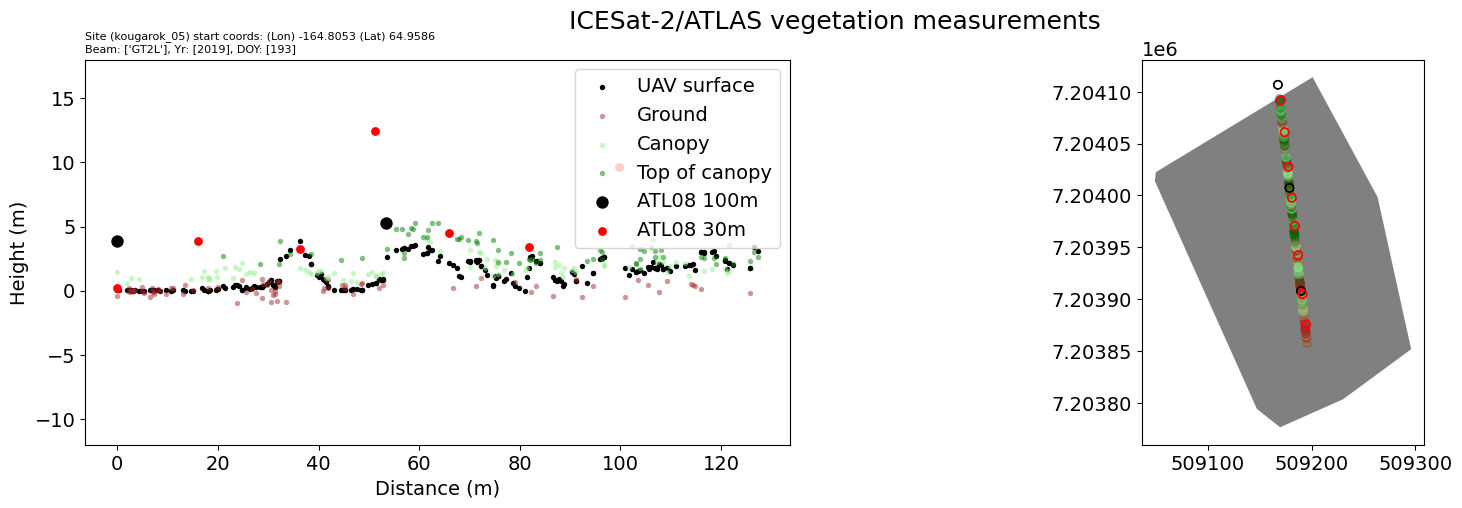

kougarok_04


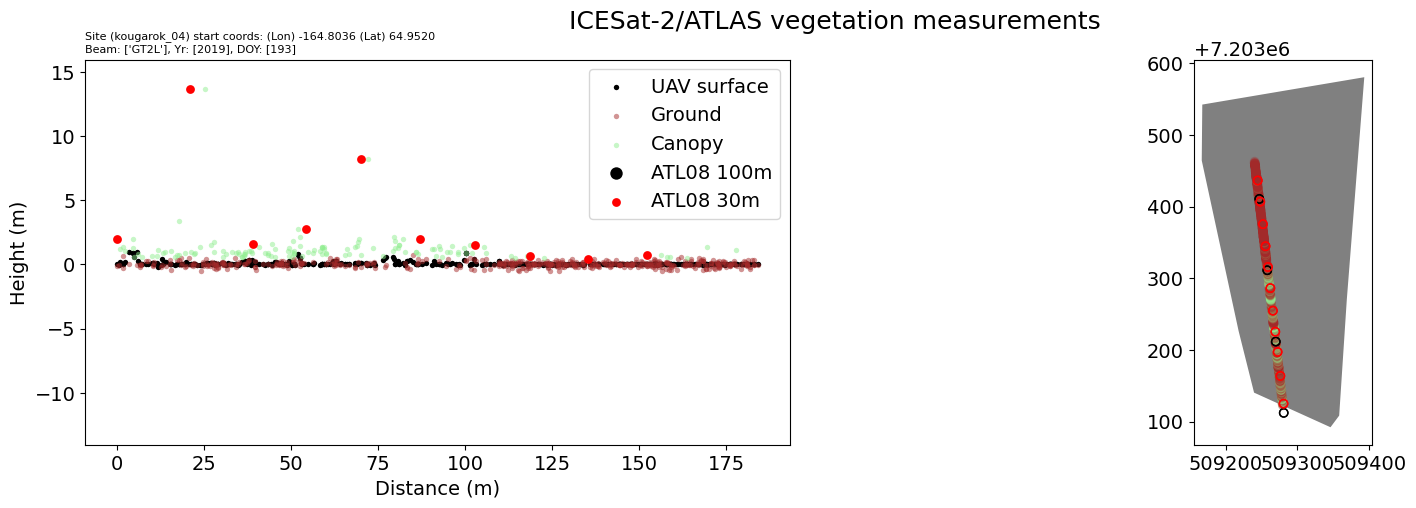

kougarok_03


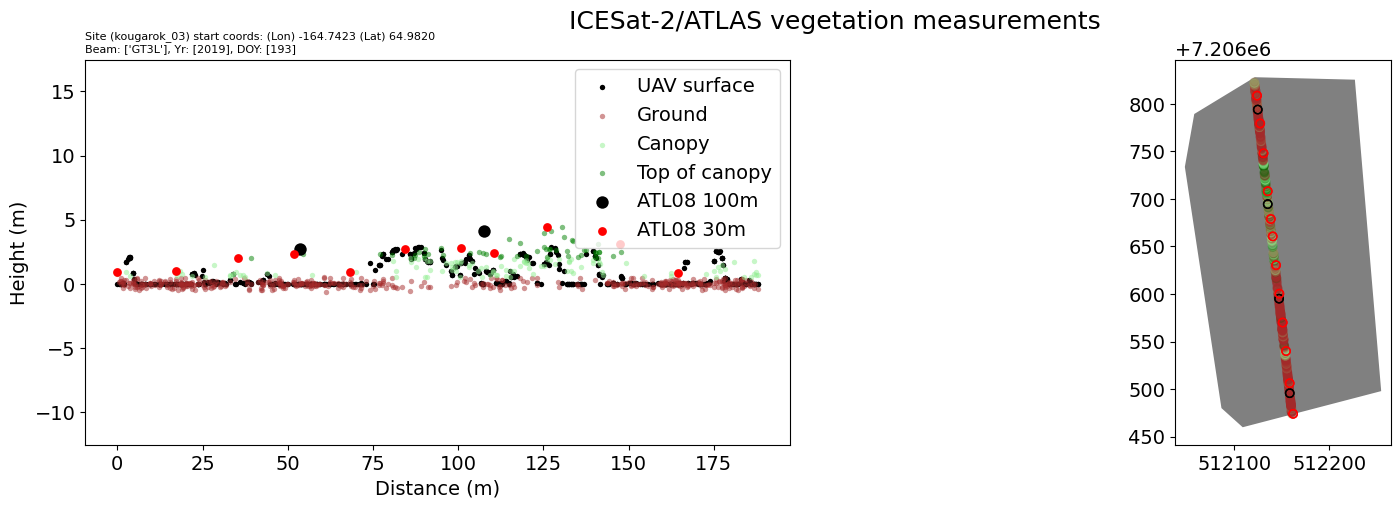

kougarok_02


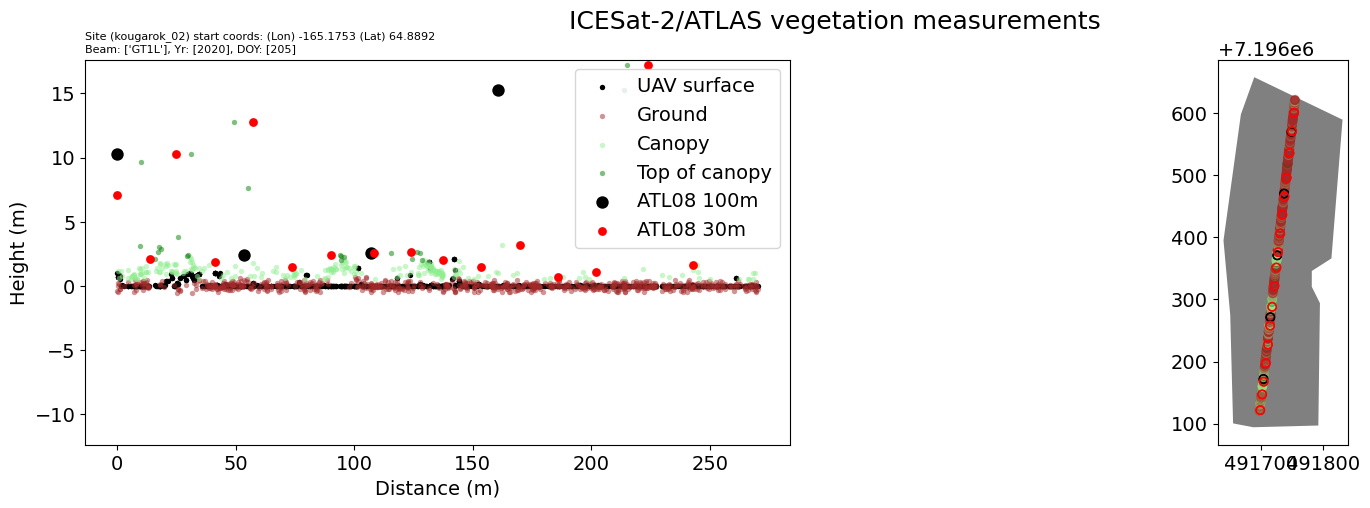

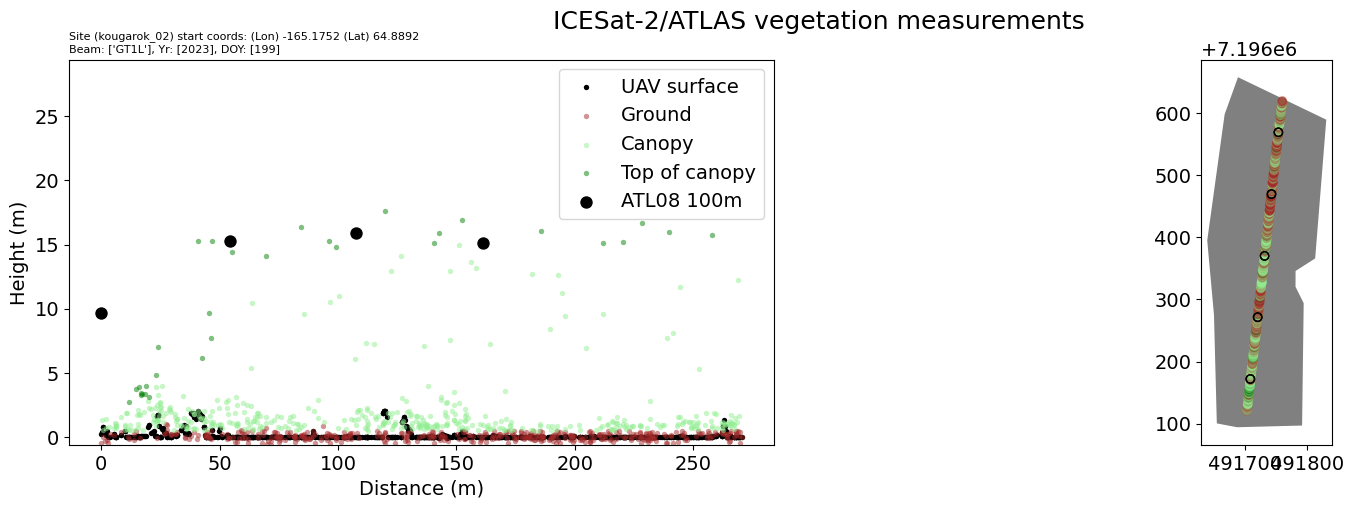

kougarok_01


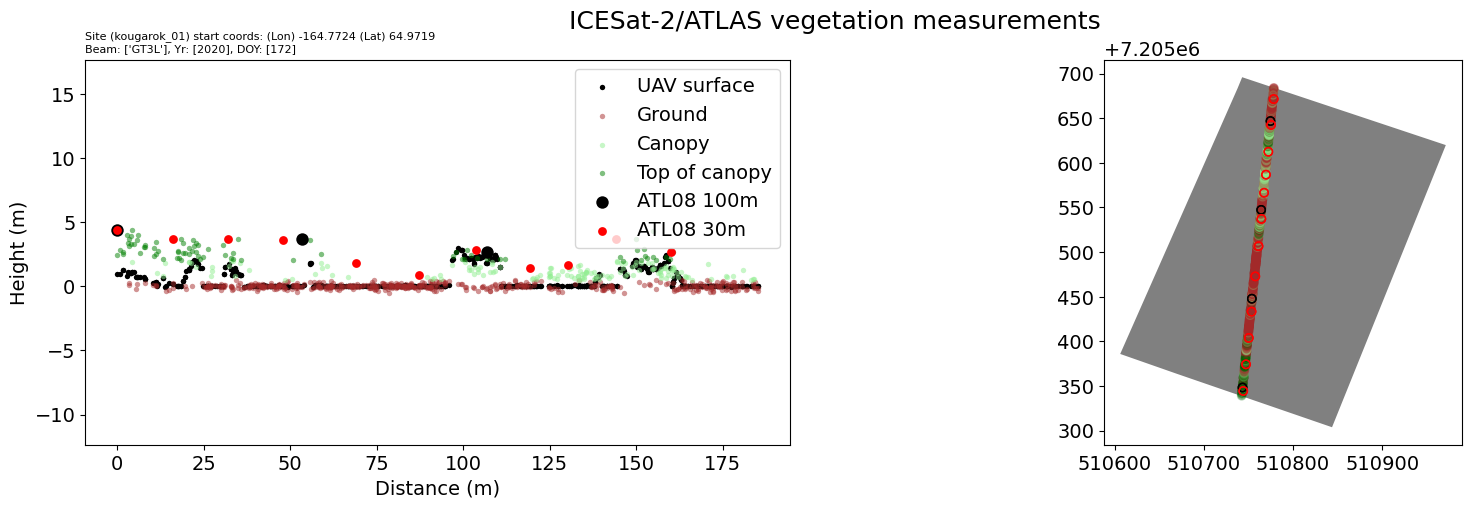

council_02


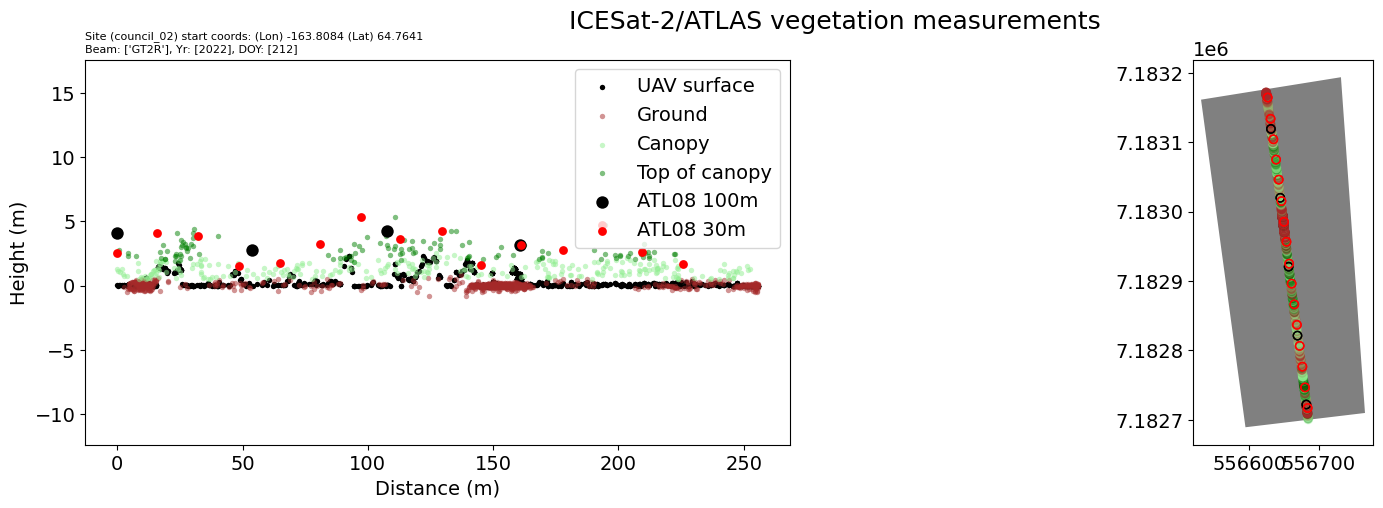

council_01


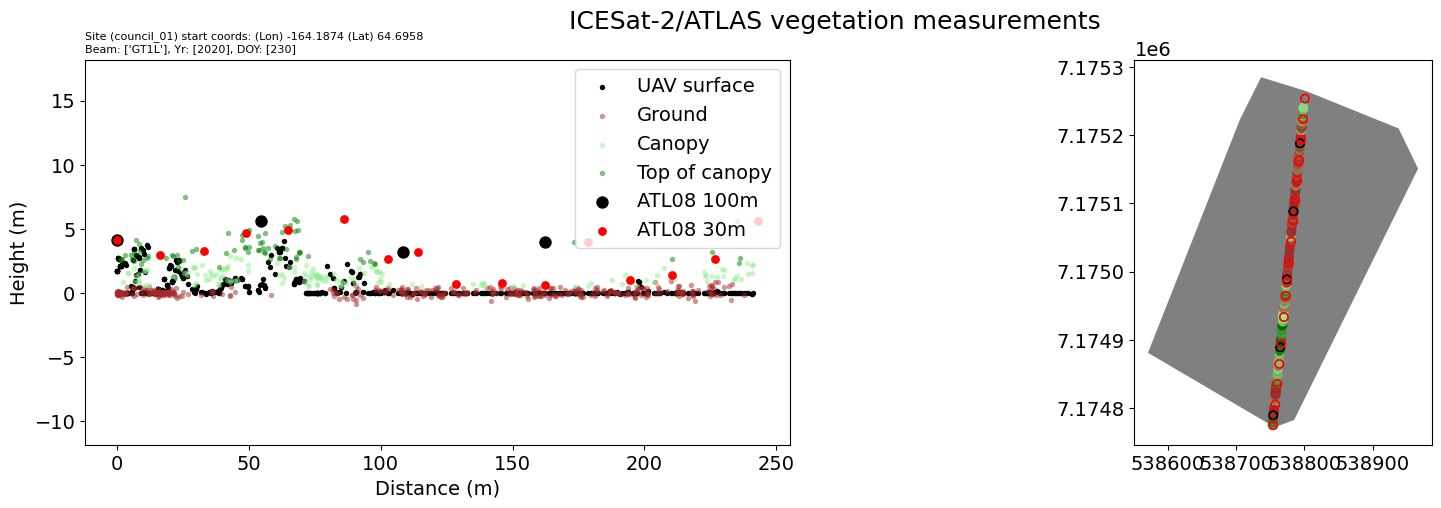

In [88]:
for site in reversed(atl03_field_gdf.site.unique()):
    print(site)
    # Remove rows where dsm values are NA
    atl03_TMP = atl03_field_gdf[atl03_field_gdf.dsm_uav != -10000]
    plotlib.plot_atl03_transect(start=0, transect_length=50000, DO_HEIGHT=True, atl03_gdf=atl03_TMP[atl03_TMP.site == site], atl08_100m_gdf=atl08_field_gdf[atl08_field_gdf.site == site], 
                                atl08_30m_gdf=atl08_30m_field_gdf[atl08_30m_field_gdf.site == site], footprint_uav_gdf=footprint_uav_gdf[footprint_uav_gdf.site == site],
                               site=site, PLOT_UAV=True)

teller_01


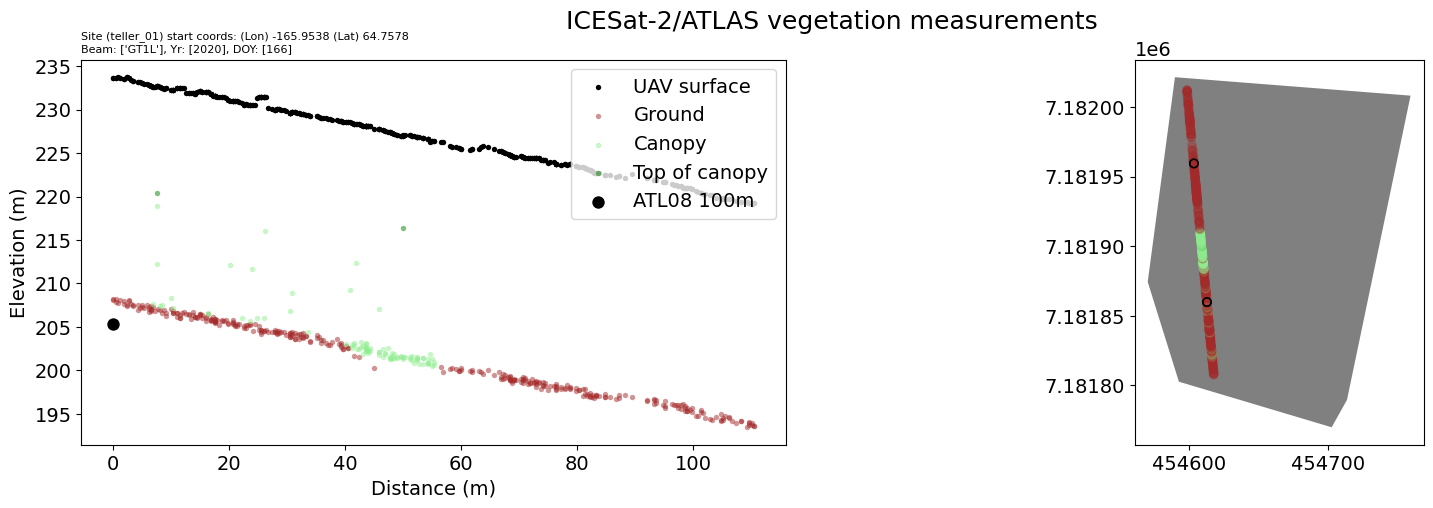

kougarok_06


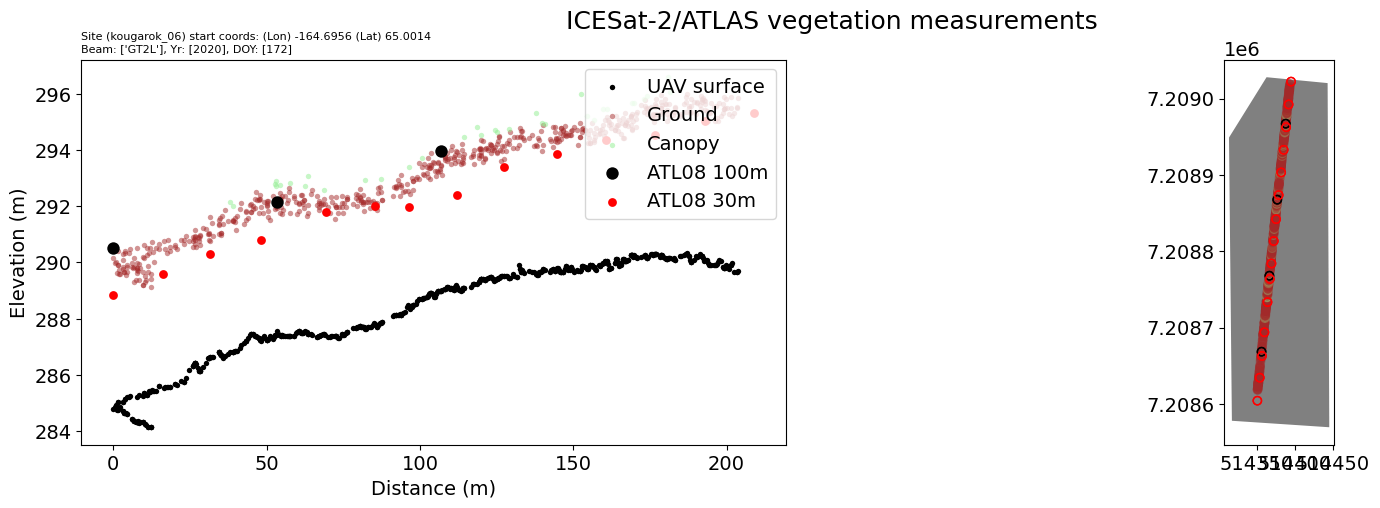

kougarok_05


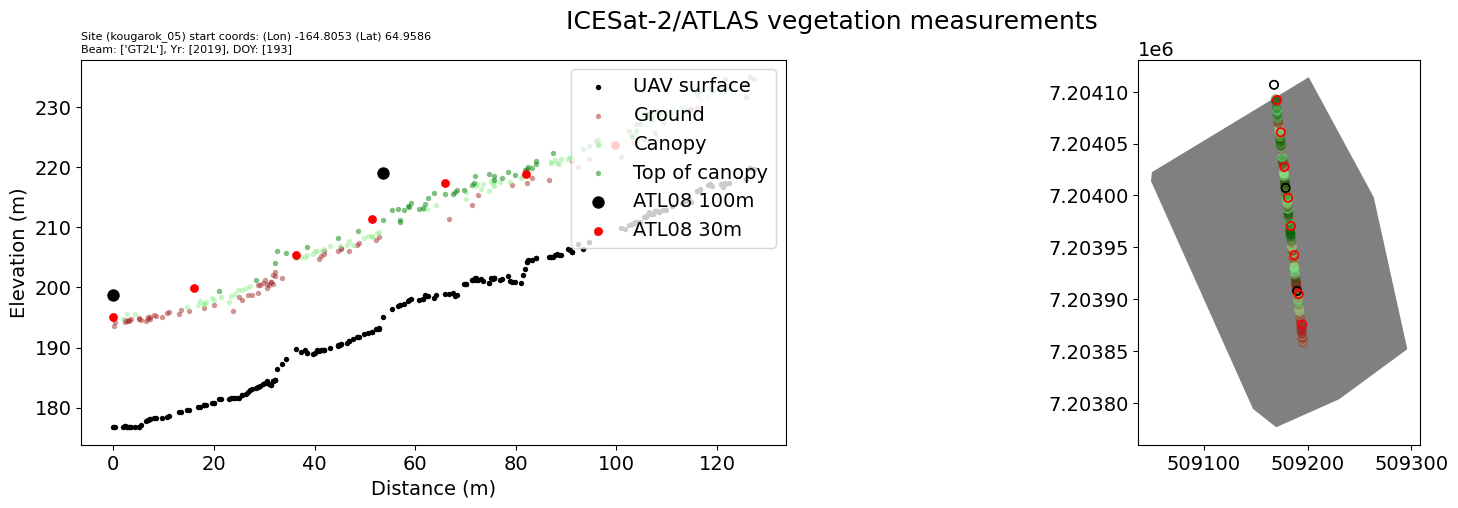

kougarok_04


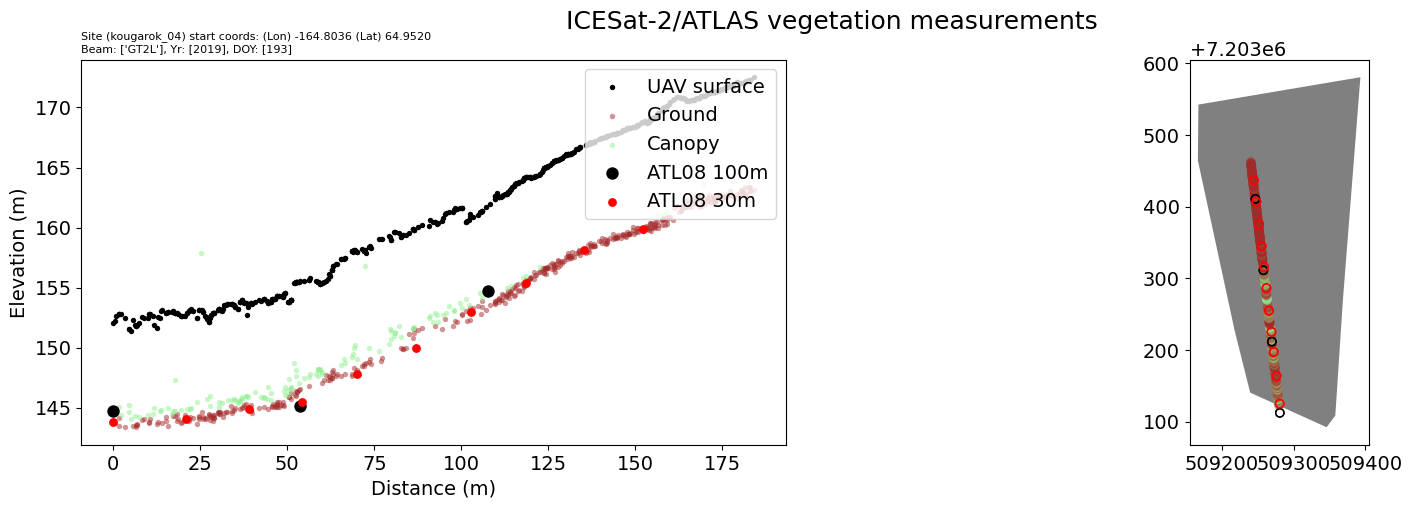

kougarok_03


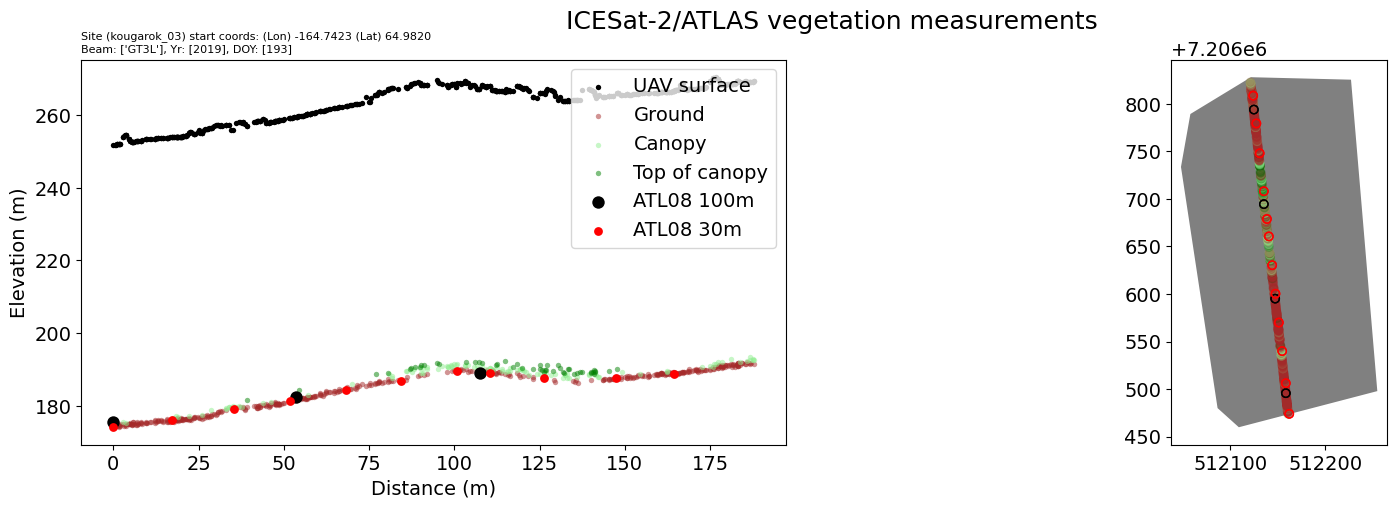

kougarok_02


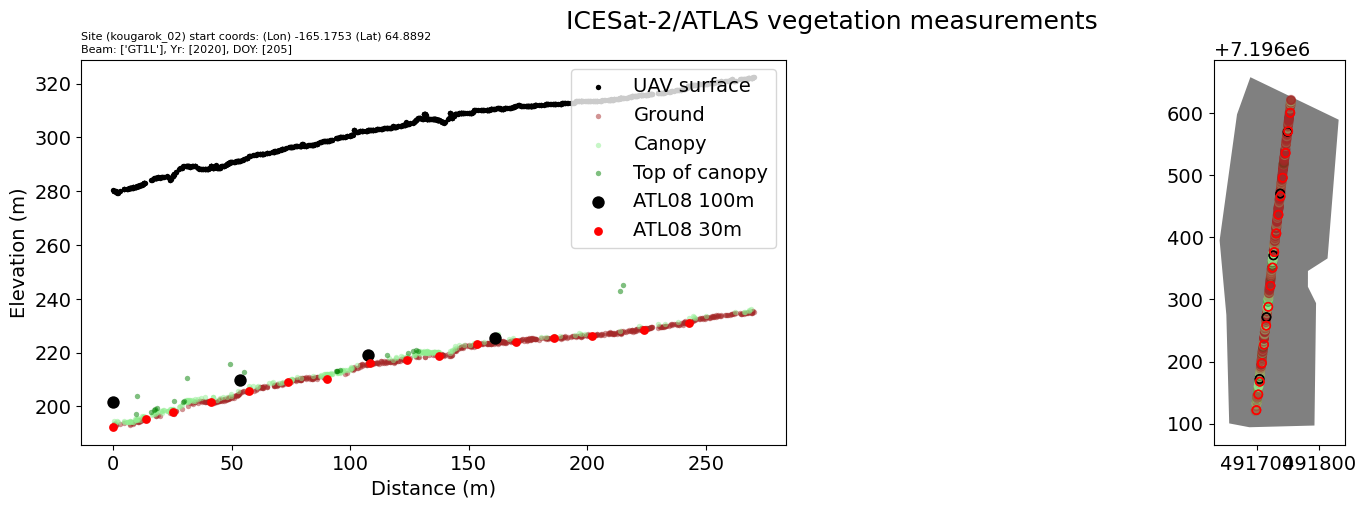

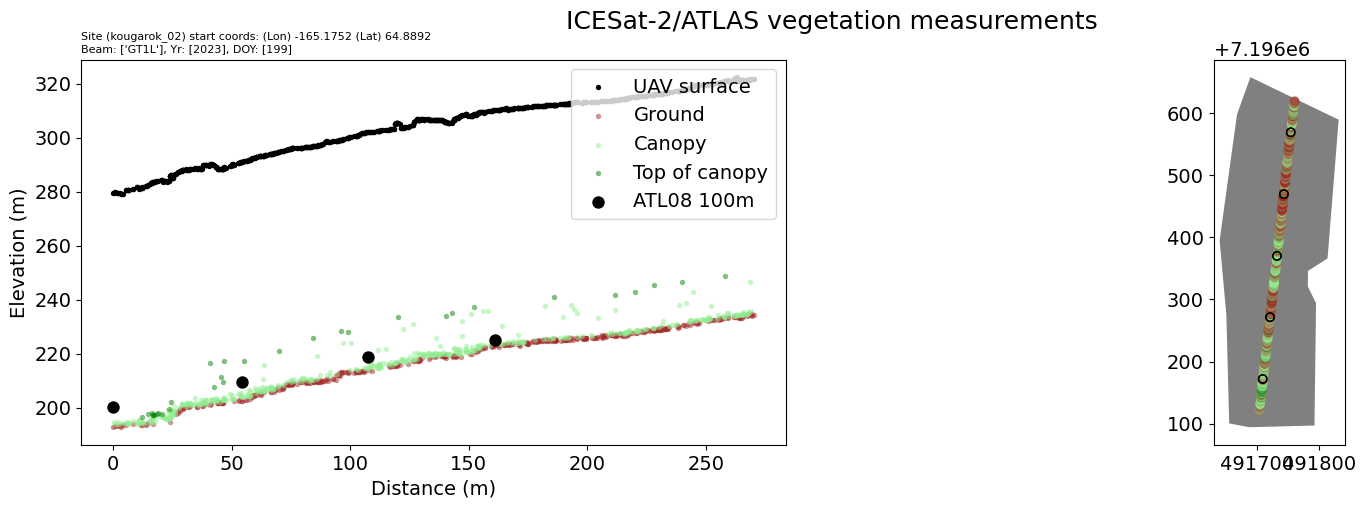

kougarok_01


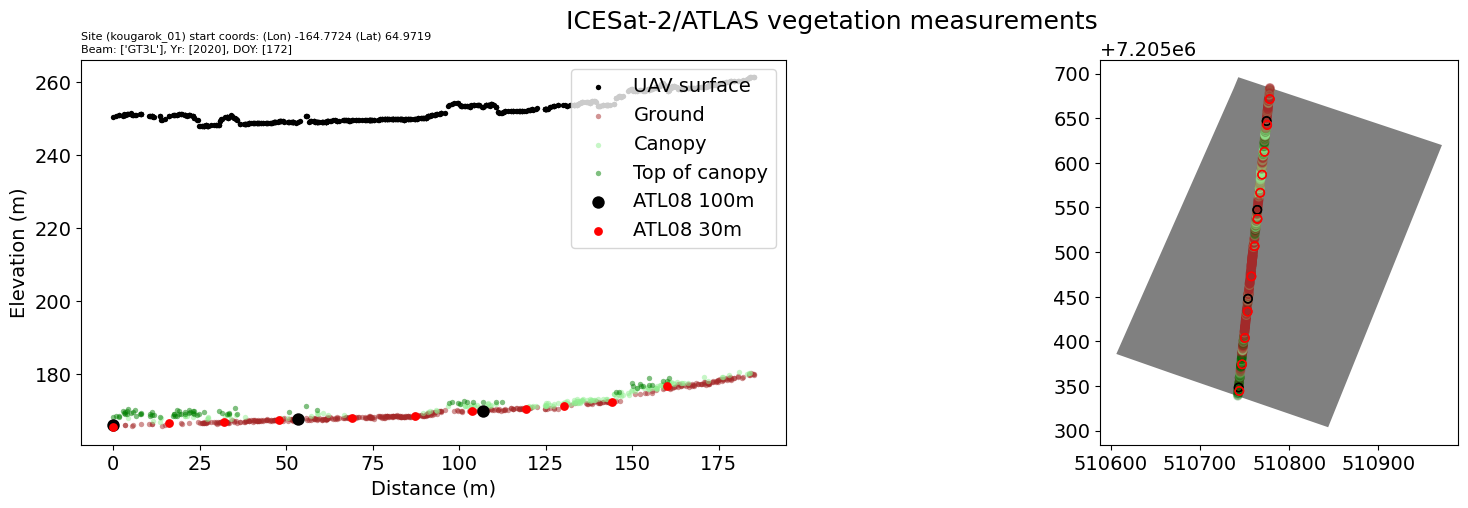

council_02


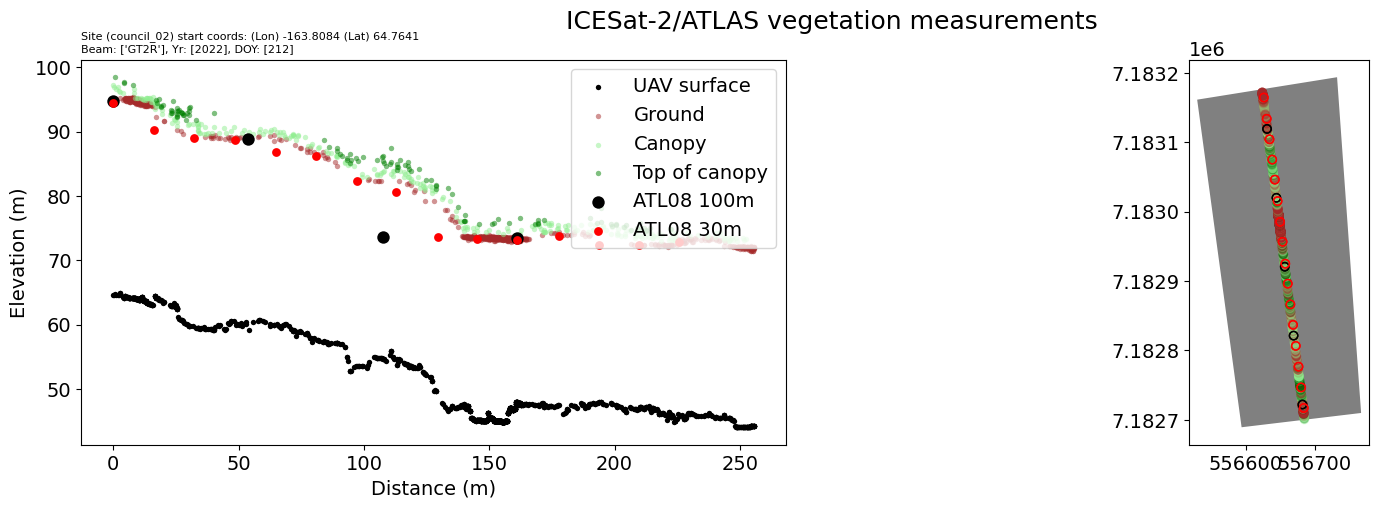

council_01


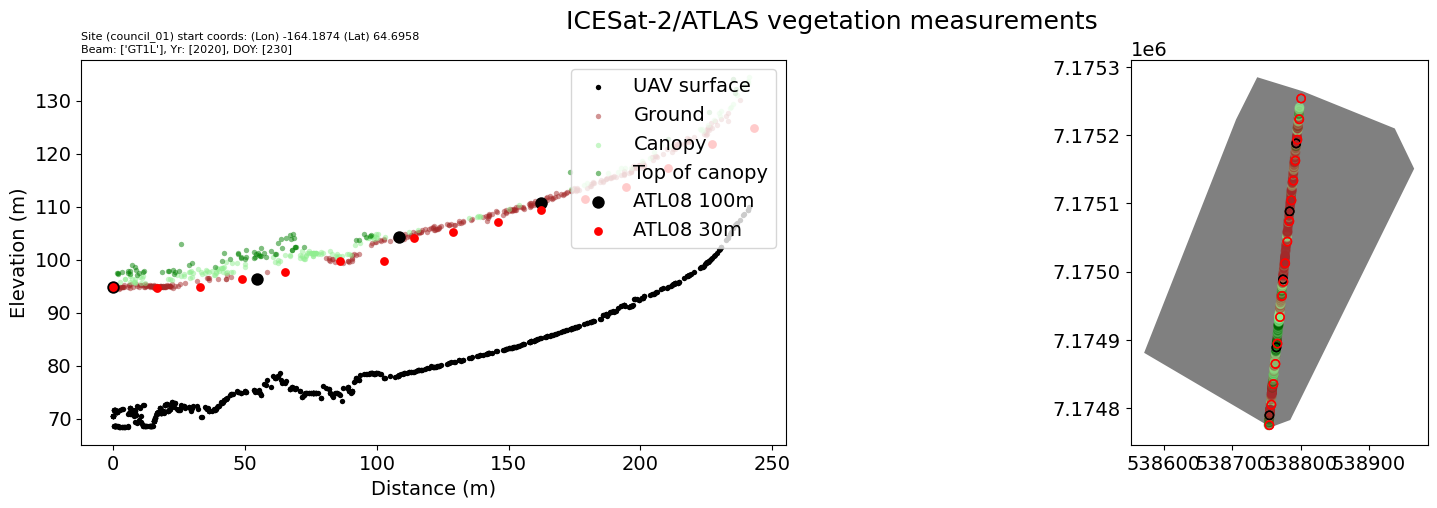

In [89]:
for site in reversed(atl03_field_gdf.site.unique()):
    print(site)
    # Remove rows where dsm values are NA
    atl03_TMP = atl03_field_gdf[atl03_field_gdf.dsm_uav != -10000]
    plotlib.plot_atl03_transect(start=0, transect_length=50000, DO_HEIGHT=False, atl03_gdf=atl03_TMP[atl03_TMP.site == site], atl08_100m_gdf=atl08_field_gdf[atl08_field_gdf.site == site], 
                                atl08_30m_gdf=atl08_30m_field_gdf[atl08_30m_field_gdf.site == site], footprint_uav_gdf=footprint_uav_gdf[footprint_uav_gdf.site == site],
                               site=site, PLOT_UAV=True)

In [62]:
import sys
sys.path.append('/home/pmontesa/code')
import maplib
import folium
import numpy

In [59]:
import importlib
importlib.reload(maplib)
from folium import plugins

In [73]:
footprint_uav_gdf = gpd.read_file('/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs/data/field/sewardpen2024/footprints_uav_sewardpen2024_RGB_COG.gpkg').drop('date', axis=1)

In [79]:
m_atl03 = maplib.ADD_ATL03_OBS_TO_MAP(atl03_field_gdf[atl03_field_gdf['class'] > 0].drop('datetime', axis=1), footprint_uav_gdf.explore() )

In [27]:
#m_atl03